<a href="https://colab.research.google.com/github/desbaa32/Master2BD_tp_pro/blob/master/Tp_Securite_Chiffrement_symetrique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***TP Chiffrement d'une image***

In [9]:
# Installation des dépendances nécessaires
# !pip install Pillow pycryptodome numpy

import os
import numpy as np
from PIL import Image
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from Crypto.Random import get_random_bytes
import matplotlib.pyplot as plt
from io import BytesIO

#### *1) Chiffrement des images avec différents modes*

Chiffrement des images...
Chiffrement TIFF en mode ECB...
Chiffrement TIFF en mode CBC...
Chiffrement TIFF en mode OFB...
Chiffrement TIFF en mode CFB...
Chiffrement JPG en mode ECB...
Chiffrement JPG en mode CBC...
Chiffrement JPG en mode OFB...
Chiffrement JPG en mode CFB...


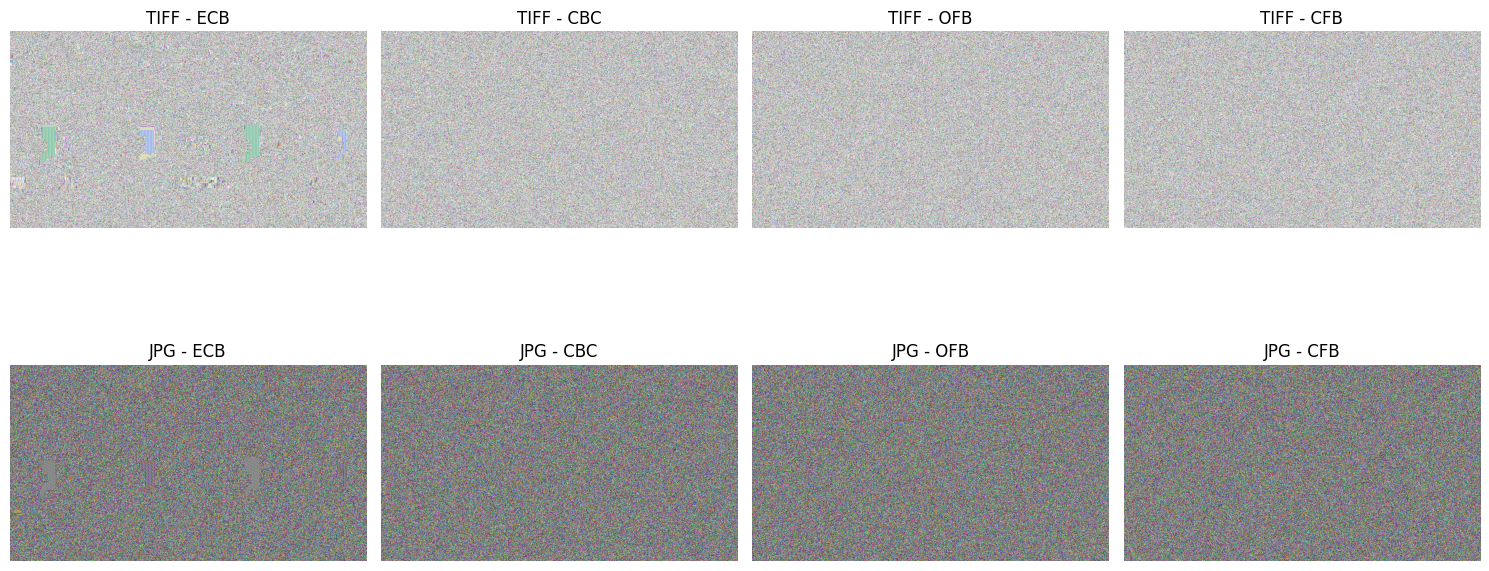

In [10]:

# Fonction de chiffrement AES
def encrypt_image_aes(image_path, mode, key):
    # Charger l'image
    img = Image.open(image_path)
    img_array = np.array(img)

    # Convertir en bytes
    if len(img_array.shape) == 3:
        height, width, channels = img_array.shape
        original_shape = img_array.shape
        img_bytes = img_array.tobytes()
    else:
        height, width = img_array.shape
        channels = 1
        original_shape = img_array.shape
        img_bytes = img_array.tobytes()

    # Préparer le chiffrement
    iv = get_random_bytes(16) if mode != AES.MODE_ECB else None

    if mode == AES.MODE_ECB:
        cipher = AES.new(key, AES.MODE_ECB)
    elif mode == AES.MODE_CBC:
        cipher = AES.new(key, AES.MODE_CBC, iv)
    elif mode == AES.MODE_OFB:
        cipher = AES.new(key, AES.MODE_OFB, iv)
    elif mode == AES.MODE_CFB:
        cipher = AES.new(key, AES.MODE_CFB, iv)
    else:
        raise ValueError("Mode non supporté")

    # Chiffrer
    padded_data = pad(img_bytes, AES.block_size)
    encrypted_data = cipher.encrypt(padded_data)

    # Reconstruire l'image chiffrée
    encrypted_array = np.frombuffer(encrypted_data, dtype=np.uint8)

    # Ajuster la forme pour la visualisation
    encrypted_img = Image.fromarray(encrypted_array[:len(img_bytes)].reshape(original_shape))

    return encrypted_img, encrypted_data, iv, original_shape

# Fonction de déchiffrement
def decrypt_image_aes(encrypted_data, mode, key, iv, original_shape):
    if mode == AES.MODE_ECB:
        cipher = AES.new(key, AES.MODE_ECB)
    elif mode == AES.MODE_CBC:
        cipher = AES.new(key, AES.MODE_CBC, iv)
    elif mode == AES.MODE_OFB:
        cipher = AES.new(key, AES.MODE_OFB, iv)
    elif mode == AES.MODE_CFB:
        cipher = AES.new(key, AES.MODE_CFB, iv)

    decrypted_data = cipher.decrypt(encrypted_data)
    decrypted_data = unpad(decrypted_data, AES.block_size)

    # Reconstruire l'image
    decrypted_array = np.frombuffer(decrypted_data, dtype=np.uint8)
    decrypted_img = Image.fromarray(decrypted_array.reshape(original_shape))

    return decrypted_img



# Clé AES (16 bytes pour AES-128)
key = get_random_bytes(16)

# Modes de chiffrement à tester
modes = {
    'ECB': AES.MODE_ECB,
    'CBC': AES.MODE_CBC,
    'OFB': AES.MODE_OFB,
    'CFB': AES.MODE_CFB
}

# Dictionnaires pour stocker les résultats
encrypted_images = {}
encryption_data = {}
# uploader images)
tiff_path="/content/Paris8.tiff"
jpg_path ="/content/Paris8.jpg"
print("Chiffrement des images...")
for image_name, image_path in [('TIFF', tiff_path), ('JPG', jpg_path)]:
    encrypted_images[image_name] = {}
    encryption_data[image_name] = {}

    for mode_name, mode in modes.items():
        print(f"Chiffrement {image_name} en mode {mode_name}...")
        encrypted_img, encrypted_bytes, iv, shape = encrypt_image_aes(image_path, mode, key)

        encrypted_images[image_name][mode_name] = encrypted_img
        encryption_data[image_name][mode_name] = {
            'bytes': encrypted_bytes,
            'iv': iv,
            'shape': shape
        }

# Afficher les images chiffrées
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for i, (image_name, modes_dict) in enumerate(encrypted_images.items()):
    for j, (mode_name, img) in enumerate(modes_dict.items()):
        axes[i, j].imshow(np.array(img))
        axes[i, j].set_title(f'{image_name} - {mode_name}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

#### *2) Calcul de l'entropie et analyse*


Image TIFF originale - Entropie: 6.6147
Mode ECB - Entropie: 7.9982
Mode CBC - Entropie: 7.9999
Mode OFB - Entropie: 7.9999
Mode CFB - Entropie: 7.9999

Image JPG originale - Entropie: 7.7690
Mode ECB - Entropie: 7.9985
Mode CBC - Entropie: 7.9999
Mode OFB - Entropie: 7.9999
Mode CFB - Entropie: 7.9999

Analyse:
Meilleur mode pour TIFF: OFB (entropie: 7.9999)
Meilleur mode pour JPG: CFB (entropie: 7.9999)


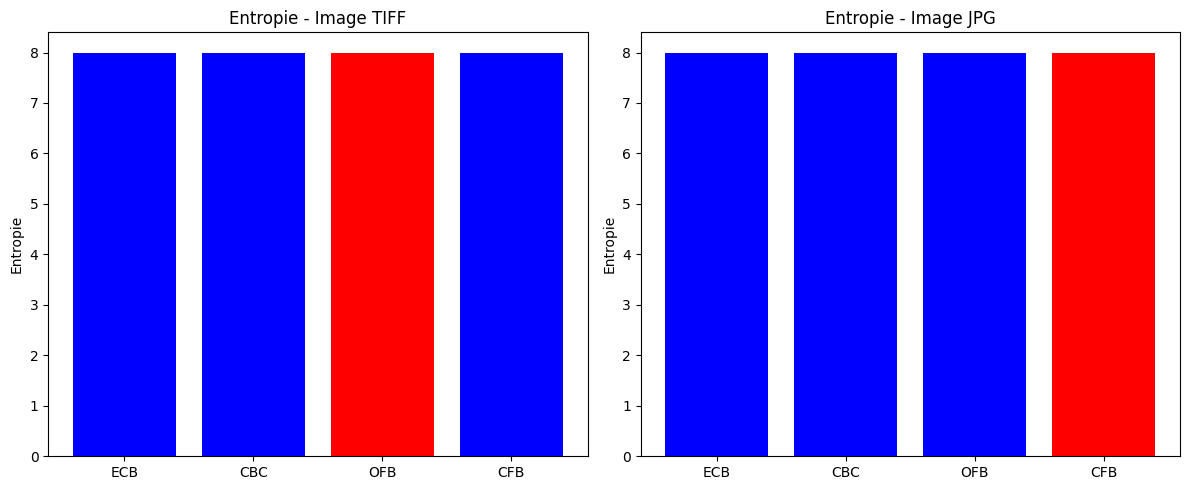

In [11]:
# Fonction pour calculer l'entropie
def calculate_entropy(data):
    if isinstance(data, np.ndarray):
        data = data.tobytes()

    byte_counts = np.zeros(256, dtype=np.int64)
    for byte in data:
        byte_counts[byte] += 1

    probabilities = byte_counts[byte_counts > 0] / len(data)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Calcul de l'entropie pour chaque image chiffrée
entropy_results = {}

for image_name in ['TIFF', 'JPG']:
    entropy_results[image_name] = {}

    # Entropie de l'image originale
    original_img = Image.open(tiff_path if image_name == 'TIFF' else jpg_path)
    original_array = np.array(original_img)
    original_entropy = calculate_entropy(original_array)

    print(f"\nImage {image_name} originale - Entropie: {original_entropy:.4f}")

    for mode_name in modes.keys():
        encrypted_bytes = encryption_data[image_name][mode_name]['bytes']
        entropy = calculate_entropy(encrypted_bytes)
        entropy_results[image_name][mode_name] = entropy
        print(f"Mode {mode_name} - Entropie: {entropy:.4f}")

# Détermination du mode le plus pertinent
print("\n" + "=" * 20)
print("Analyse:")

best_modes = {}
for image_name in ['TIFF', 'JPG']:
    max_entropy = max(entropy_results[image_name].values())
    best_mode = [mode for mode, entropy in entropy_results[image_name].items()
                if entropy == max_entropy][0]
    best_modes[image_name] = best_mode
    print(f"Meilleur mode pour {image_name}: {best_mode} (entropie: {max_entropy:.4f})")

# Visualisation graphique de l'entropie
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Pour TIFF
modes_list = list(modes.keys())
tiff_entropies = [entropy_results['TIFF'][mode] for mode in modes_list]
ax1.bar(modes_list, tiff_entropies, color=['red' if mode == best_modes['TIFF'] else 'blue' for mode in modes_list])
ax1.set_title('Entropie - Image TIFF')
ax1.set_ylabel('Entropie')

# Pour JPG
jpg_entropies = [entropy_results['JPG'][mode] for mode in modes_list]
ax2.bar(modes_list, jpg_entropies, color=['red' if mode == best_modes['JPG'] else 'blue' for mode in modes_list])
ax2.set_title('Entropie - Image JPG')
ax2.set_ylabel('Entropie')

plt.tight_layout()
plt.show()

#### 3)Compression et taux de compression

COMPRESSION DES IMAGES CHIFFRÉES:
TIFF - ECB:
  Taille originale: 2116816 bytes
  Taille compressée: 1900503 bytes
  Taux de compression: 10.22%

TIFF - CBC:
  Taille originale: 2116816 bytes
  Taille compressée: 2117472 bytes
  Taux de compression: -0.03%

TIFF - OFB:
  Taille originale: 2116816 bytes
  Taille compressée: 2117472 bytes
  Taux de compression: -0.03%

TIFF - CFB:
  Taille originale: 2116816 bytes
  Taille compressée: 2117472 bytes
  Taux de compression: -0.03%

JPG - ECB:
  Taille originale: 1587616 bytes
  Taille compressée: 1541682 bytes
  Taux de compression: 2.89%

JPG - CBC:
  Taille originale: 1587616 bytes
  Taille compressée: 1588107 bytes
  Taux de compression: -0.03%

JPG - OFB:
  Taille originale: 1587616 bytes
  Taille compressée: 1588107 bytes
  Taux de compression: -0.03%

JPG - CFB:
  Taille originale: 1587616 bytes
  Taille compressée: 1588107 bytes
  Taux de compression: -0.03%



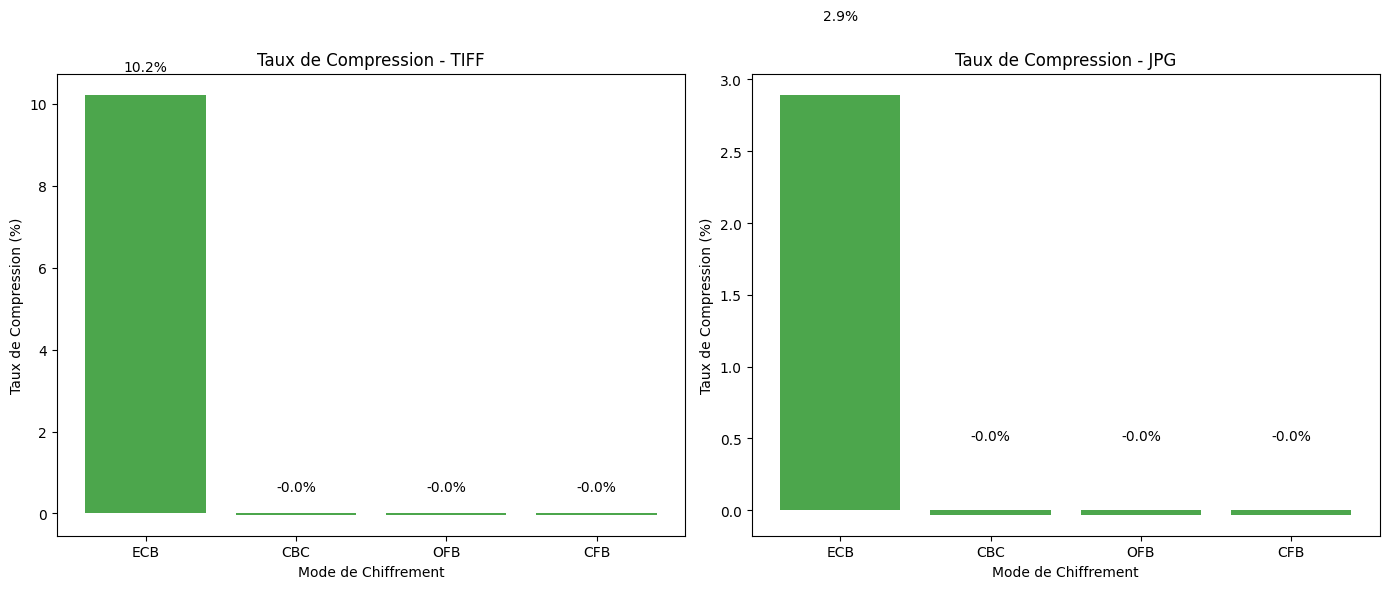

In [12]:
import zlib

def compress_data(data):
    """Compresse les données avec zlib"""
    return zlib.compress(data)

def calculate_compression_rate(original_data, compressed_data):
    """Calcule le taux de compression"""
    original_size = len(original_data)
    compressed_size = len(compressed_data)
    compression_rate = (1 - compressed_size / original_size) * 100
    return compression_rate, original_size, compressed_size

# Compression des images chiffrées
compression_results = {}

print("COMPRESSION DES IMAGES CHIFFRÉES:")
for image_name in ['TIFF', 'JPG']:
    compression_results[image_name] = {}

    for mode_name in modes.keys():
        encrypted_bytes = encryption_data[image_name][mode_name]['bytes']

        # Compression
        compressed_data = compress_data(encrypted_bytes)

        # Calcul du taux de compression
        compression_rate, original_size, compressed_size = calculate_compression_rate(
            encrypted_bytes, compressed_data
        )

        compression_results[image_name][mode_name] = {
            'compressed_data': compressed_data,
            'rate': compression_rate,
            'original_size': original_size,
            'compressed_size': compressed_size
        }

        print(f"{image_name} - {mode_name}:")
        print(f"  Taille originale: {original_size} bytes")
        print(f"  Taille compressée: {compressed_size} bytes")
        print(f"  Taux de compression: {compression_rate:.2f}%")
        print()

# Visualisation des taux de compression
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, image_name in enumerate(['TIFF', 'JPG']):
    modes_list = list(modes.keys())
    rates = [compression_results[image_name][mode]['rate'] for mode in modes_list]

    bars = axes[idx].bar(modes_list, rates, color='green', alpha=0.7)
    axes[idx].set_title(f'Taux de Compression - {image_name}')
    axes[idx].set_ylabel('Taux de Compression (%)')
    axes[idx].set_xlabel('Mode de Chiffrement')

    # Ajouter les valeurs sur les barres
    for bar, rate in zip(bars, rates):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{rate:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### *4) Modification d'un octet et déchiffrement*

MODIFICATION D'UN OCTET - IMAGES NON COMPRESSÉES:

TIFF - Mode ECB:
  Modification à la position 84800: 7D → 82
  Déchiffrement: RÉUSSI

TIFF - Mode CBC:
  Modification à la position 1711736: 32 → CD
  Déchiffrement: RÉUSSI

TIFF - Mode OFB:
  Modification à la position 704949: E3 → 1C
  Déchiffrement: RÉUSSI

TIFF - Mode CFB:
  Modification à la position 735059: C8 → 37
  Déchiffrement: RÉUSSI

JPG - Mode ECB:
  Modification à la position 1214744: 62 → 9D
  Déchiffrement: RÉUSSI

JPG - Mode CBC:
  Modification à la position 389369: 5C → A3
  Déchiffrement: RÉUSSI

JPG - Mode OFB:
  Modification à la position 1172361: BD → 42
  Déchiffrement: RÉUSSI

JPG - Mode CFB:
  Modification à la position 1388436: CD → 32
  Déchiffrement: RÉUSSI


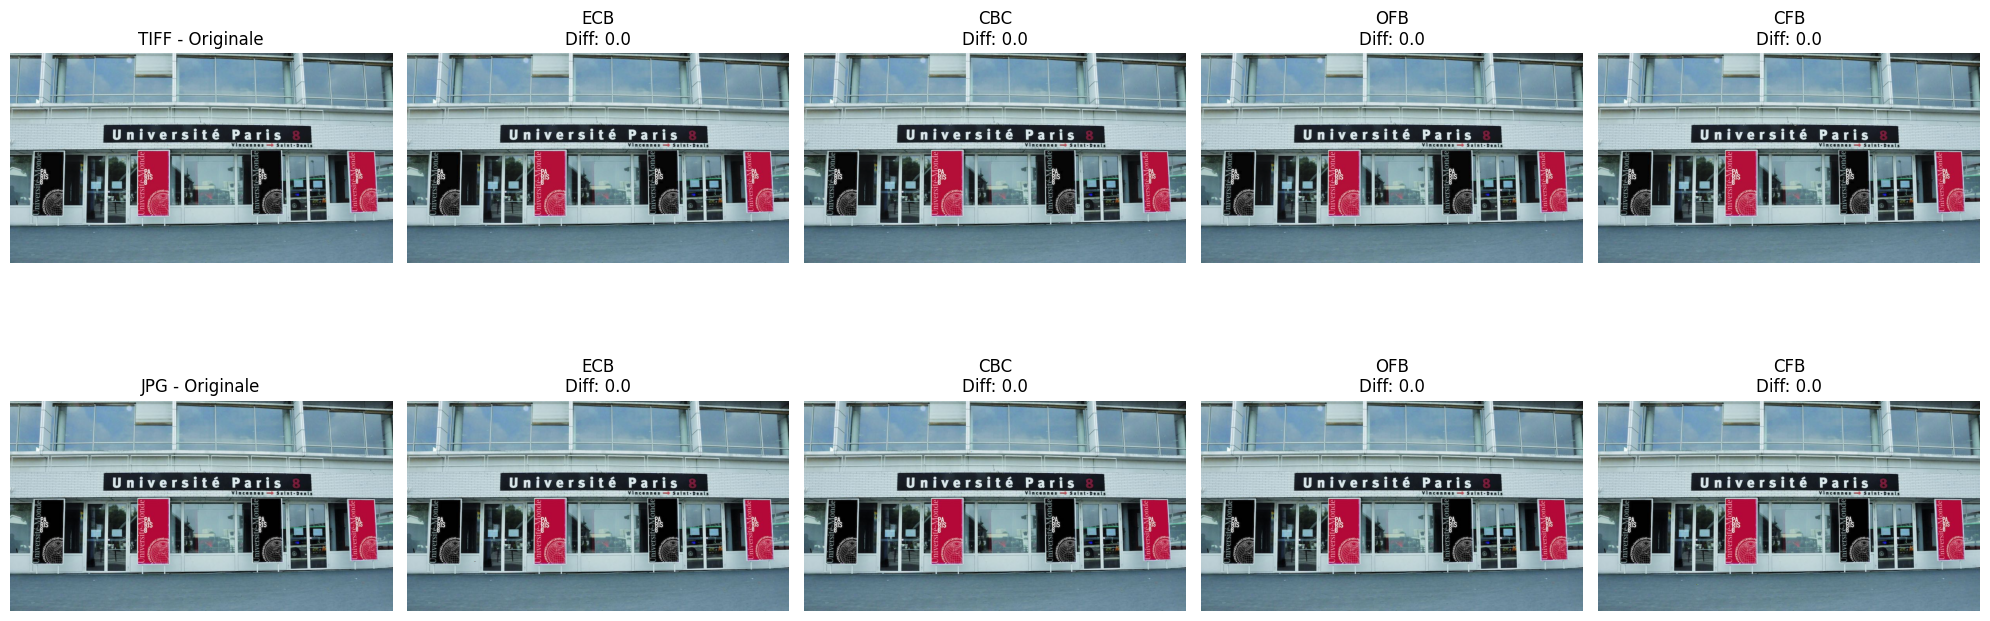

In [13]:
def modify_one_byte(data, position=None):
    """Modifie un octet aléatoire dans les données"""
    data_bytearray = bytearray(data)

    if position is None:
        position = np.random.randint(0, len(data_bytearray))

    # Modifier l'octet (XOR avec 0xFF pour inverser tous les bits)
    original_byte = data_bytearray[position]
    data_bytearray[position] = original_byte ^ 0xFF
    modified_byte = data_bytearray[position]

    return bytes(data_bytearray), position, original_byte, modified_byte

# Test de modification sur images non compressées
print("MODIFICATION D'UN OCTET - IMAGES NON COMPRESSÉES:")

modification_results = {}

for image_name in ['TIFF', 'JPG']:
    modification_results[image_name] = {}

    for mode_name in modes.keys():
        print(f"\n{image_name} - Mode {mode_name}:")

        # Récupérer les données chiffrées
        encrypted_data = encryption_data[image_name][mode_name]['bytes']
        iv = encryption_data[image_name][mode_name]['iv']
        shape = encryption_data[image_name][mode_name]['shape']

        # Modifier un octet
        modified_data, pos, orig_byte, mod_byte = modify_one_byte(encrypted_data)

        # Déchiffrer l'image modifiée
        try:
            decrypted_modified = decrypt_image_aes(modified_data, modes[mode_name], key, iv, shape)
            modification_results[image_name][mode_name] = {
                'success': True,
                'decrypted_image': decrypted_modified,
                'position': pos,
                'original_byte': orig_byte,
                'modified_byte': mod_byte
            }
            print(f"  Modification à la position {pos}: {orig_byte:02X} → {mod_byte:02X}")
            print(f"  Déchiffrement: RÉUSSI")

        except Exception as e:
            modification_results[image_name][mode_name] = {
                'success': False,
                'error': str(e)
            }
            print(f"  Déchiffrement: ÉCHEC - {e}")

# Affichage comparatif des images déchiffrées après modification
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, image_name in enumerate(['TIFF', 'JPG']):
    # Image originale
    original_img = Image.open(tiff_path if image_name == 'TIFF' else jpg_path)
    axes[i, 0].imshow(np.array(original_img))
    axes[i, 0].set_title(f'{image_name} - Originale')
    axes[i, 0].axis('off')

    for j, mode_name in enumerate(modes.keys(), 1):
        if modification_results[image_name][mode_name]['success']:
            decrypted_img = modification_results[image_name][mode_name]['decrypted_image']
            axes[i, j].imshow(np.array(decrypted_img))

            # Calculer la différence avec l'original
            diff = np.mean(np.abs(np.array(decrypted_img) - np.array(original_img)))
            axes[i, j].set_title(f'{mode_name}\nDiff: {diff:.1f}')
        else:
            axes[i, j].text(0.5, 0.5, 'Échec\ndéchiffrement',
                           ha='center', va='center', transform=axes[i, j].transAxes)
            axes[i, j].set_title(f'{mode_name} - Erreur')

        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

#### *5) Modification sur images compressées*

MODIFICATION D'UN OCTET - IMAGES COMPRESSÉES:

TIFF - Mode ECB:
  Modification à la position 1774882: 73 → 8C
  Décompression: ÉCHEC
  Déchiffrement: ÉCHEC - Data must be aligned to block boundary in ECB mode

TIFF - Mode CBC:
  Modification à la position 227210: F5 → 0A
  Décompression: ÉCHEC
  Déchiffrement: ÉCHEC - Padding is incorrect.

TIFF - Mode OFB:
  Modification à la position 292456: 8F → 70
  Décompression: ÉCHEC
  Déchiffrement: ÉCHEC - Padding is incorrect.

TIFF - Mode CFB:
  Modification à la position 1440325: 0C → F3
  Décompression: ÉCHEC
  Déchiffrement: ÉCHEC - Padding is incorrect.

JPG - Mode ECB:
  Modification à la position 1229509: 19 → E6
  Décompression: ÉCHEC
  Déchiffrement: ÉCHEC - Data must be aligned to block boundary in ECB mode

JPG - Mode CBC:
  Modification à la position 1131955: CD → 32
  Décompression: ÉCHEC
  Déchiffrement: ÉCHEC - Data must be padded to 16 byte boundary in CBC mode

JPG - Mode OFB:
  Modification à la position 1467112: CD → 32
  D

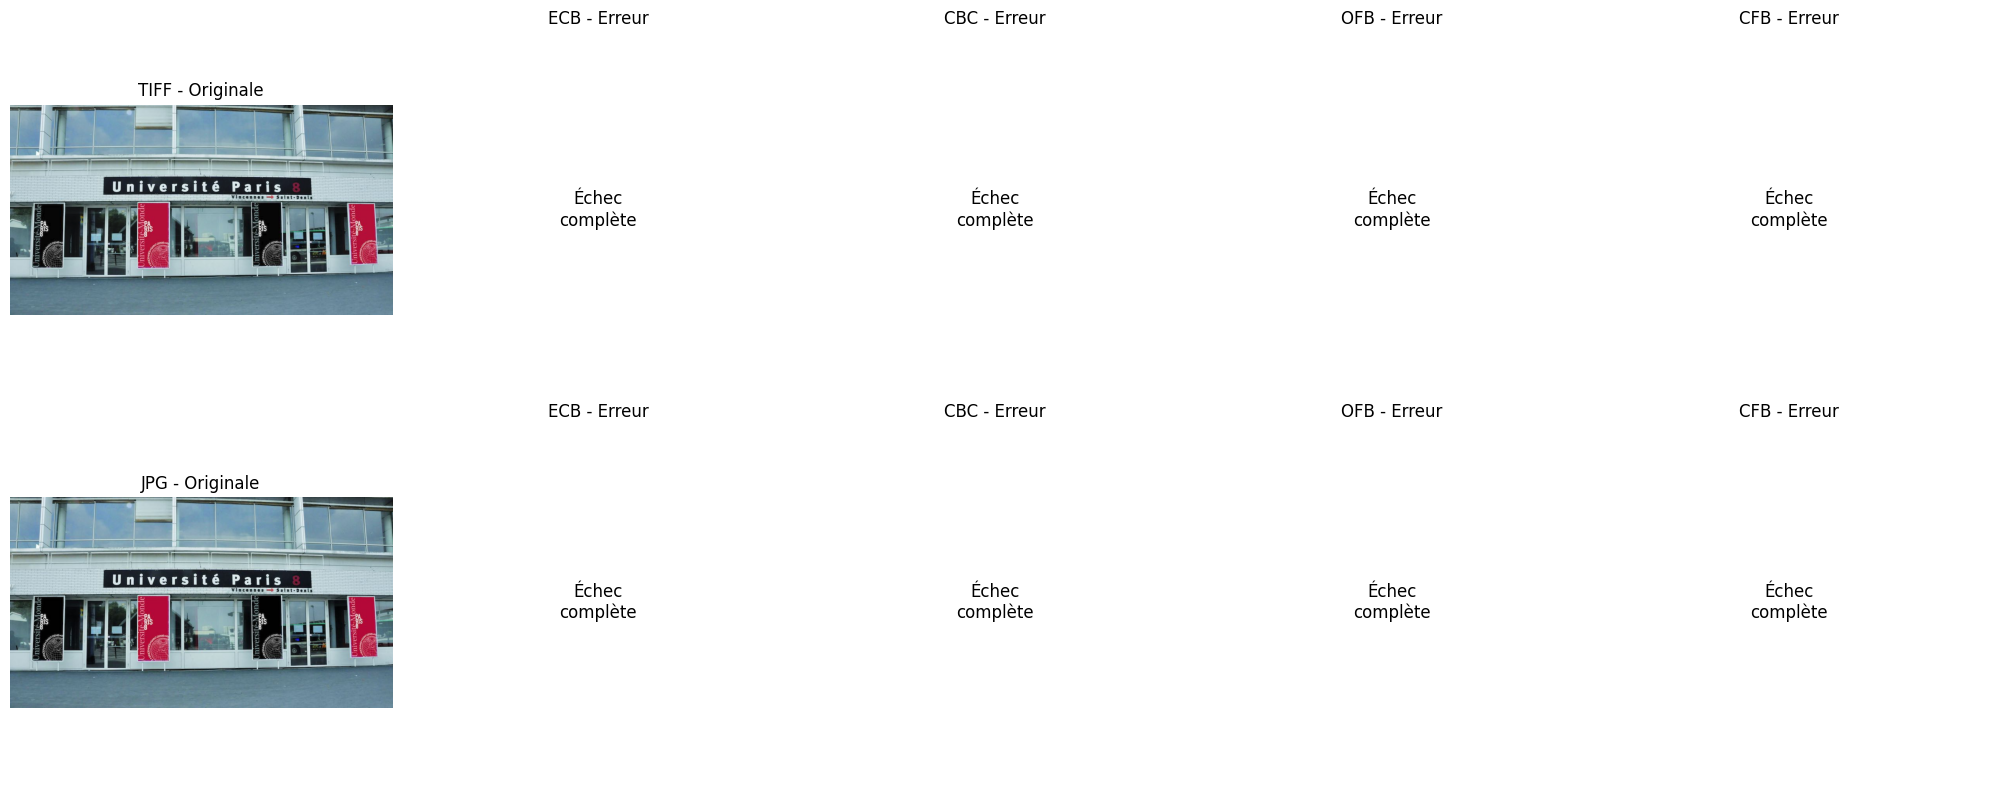

In [14]:
# Test de modification sur images compressées
print("MODIFICATION D'UN OCTET - IMAGES COMPRESSÉES:")
print("=" * 70)

compressed_modification_results = {}

for image_name in ['TIFF', 'JPG']:
    compressed_modification_results[image_name] = {}

    for mode_name in modes.keys():
        print(f"\n{image_name} - Mode {mode_name}:")

        # Récupérer les données compressées
        compressed_data = compression_results[image_name][mode_name]['compressed_data']
        iv = encryption_data[image_name][mode_name]['iv']
        shape = encryption_data[image_name][mode_name]['shape']

        # Modifier un octet
        modified_compressed, pos, orig_byte, mod_byte = modify_one_byte(compressed_data)

        print(f"  Modification à la position {pos}: {orig_byte:02X} → {mod_byte:02X}")

        try:
            # Décompresser
            try:
                decompressed_data = zlib.decompress(modified_compressed)
                decompression_success = True
                print("  Décompression: RÉUSSI")
            except:
                decompression_success = False
                print("  Décompression: ÉCHEC")
                # Pour la démonstration, on essaie quand même de déchiffrer
                decompressed_data = modified_compressed

            # Déchiffrer
            if decompression_success:
                decrypted_img = decrypt_image_aes(decompressed_data, modes[mode_name], key, iv, shape)
                compressed_modification_results[image_name][mode_name] = {
                    'decompression_success': True,
                    'decryption_success': True,
                    'decrypted_image': decrypted_img
                }
                print("  Déchiffrement: RÉUSSI")
            else:
                # Essayer de déchiffrer directement les données compressées modifiées
                try:
                    # Tenter de déchiffrer sans décompression
                    # Note: Ceci échouera probablement car les données ne sont pas pad correctement
                    decrypted_img = decrypt_image_aes(modified_compressed, modes[mode_name], key, iv, shape)
                    compressed_modification_results[image_name][mode_name] = {
                        'decompression_success': False,
                        'decryption_success': True,
                        'decrypted_image': decrypted_img
                    }
                    print("  Déchiffrement: RÉUSSI (sans décompression)")
                except Exception as e:
                    compressed_modification_results[image_name][mode_name] = {
                        'decompression_success': False,
                        'decryption_success': False,
                        'error': str(e)
                    }
                    print(f"  Déchiffrement: ÉCHEC - {e}")

        except Exception as e:
            compressed_modification_results[image_name][mode_name] = {
                'decompression_success': False,
                'decryption_success': False,
                'error': str(e)
            }
            print(f"  Déchiffrement: ÉCHEC - {e}")

# Affichage comparatif
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, image_name in enumerate(['TIFF', 'JPG']):
    # Image originale
    original_img = Image.open(tiff_path if image_name == 'TIFF' else jpg_path)
    axes[i, 0].imshow(np.array(original_img))
    axes[i, 0].set_title(f'{image_name} - Originale')
    axes[i, 0].axis('off')

    for j, mode_name in enumerate(modes.keys(), 1):
        result = compressed_modification_results[image_name][mode_name]

        if result.get('decryption_success', False):
            decrypted_img = result['decrypted_image']
            axes[i, j].imshow(np.array(decrypted_img))

            status = "Décomp: OUI" if result.get('decompression_success', False) else "Décomp: NON"
            axes[i, j].set_title(f'{mode_name}\n{status}')
        else:
            axes[i, j].text(0.5, 0.5, 'Échec\ncomplète',
                           ha='center', va='center', transform=axes[i, j].transAxes,
                           fontsize=12)
            axes[i, j].set_title(f'{mode_name} - Erreur')

        axes[i, j].axis('off')

plt.tight_layout()
plt.show()
